# Importance sampling — infinite variance example

We seek to estimate the value function under the policy $\pi(\text{left}|s) = 1$ when the simulations are being sampled according to $\pi(\text{left} | s) = 1/2$.

The estimate of the value function $v_\pi(s)$ under ordinary importance sampling is given by

$$
     V(s) = \frac{\sum_{t\in{\mathfrak T}(s)} \rho_{t:T(t) -1}G_t}{| \mathfrak{T}(s) |}
$$
with
* $\mathfrak{T}(s)$ the set of all time steps in which state $s$ is visited,
* $T(t)$ the first time of termination following $t$
* $G_t$ the return after $t$ up though $T(t)$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import njit, prange

In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
# transition_matrix[left/right, state/end_state]
transition_matrix = np.array([
    [0.9, 0.1],
    [0.0, 1.0]
])


reward_matrix = np.array([
    [0.0,     1.0],
    [-np.inf, 0.0]
])

In [30]:
@njit
def set_seed(seed):
    np.random.seed(seed)
    

@njit
def step(state, policy):
    pr_actions = policy[state]
    action = np.random.multinomial(1, pvals=pr_actions).argmax()
    
    next_state = np.random.multinomial(1, pvals=transition_matrix[action]).argmax()
    ret = reward_matrix[action, next_state]
    
    return action, next_state, ret


@njit
def episode(state, policy):
    states, actions, returns = [state], [], []
    while state != 1:
        action, state, ret = step(state, policy)
        states.append(state)
        actions.append(action)
        returns.append(ret)
    
    states = np.array(states)
    actions = np.array(actions)
    returns = np.array(returns)
    return states, actions, returns


@njit
def value_function_is(n_sims, policy_behaviour, policy_target):
    rewards_all = []
    rho_all = []
    actions_all = []
    
    for n in range(n_sims):
        states, actions, returns = episode(0, policy_behaviour)
        rewards = returns[::-1].cumsum()#[::-1]
        # rho_vals = policy_target[states[:-1], actions] / policy_behaviour[states[:-1], actions]
        states_pre = states[:-1]
        rho_vals = (
            policy_target[:, actions].take(states_pre) / 
            policy_behaviour[:, actions].take(states_pre)
        )
        
        actions_all.extend(actions)
        rewards_all.extend(rewards)
        rho_all.extend(rho_vals)
    
    actions_all = np.array(actions_all)
    rewards_all = np.array(rewards_all)
    rho_all = np.array(rho_all)
    return rewards_all, rho_all, actions_all

In [31]:
policy_behaviour = np.zeros((
    1, # non-terminal state
    2, # left or right
))

policy_behaviour[0, 0] = 1/2
policy_behaviour[0, 1] = 1/2

In [32]:
policy_target = np.zeros_like(policy_behaviour)
policy_target[0, 0] = 1.0

In [33]:
# set_seed(11111)
states, actions, returns = episode(0, policy_behaviour)
rewards = returns[::-1].cumsum()[::-1]

In [34]:
states

array([0, 0, 1])

In [35]:
rho_vals = policy_target[states[:-1], actions] / policy_behaviour[states[:-1], actions]

In [62]:
set_seed(314)
rewards, rho, actions = value_function_is(1_000, policy_behaviour, policy_target)

In [63]:
pd.Series(rewards).describe()

count    1861.00000
mean        0.09726
std         0.29639
min         0.00000
25%         0.00000
50%         0.00000
75%         0.00000
max         1.00000
dtype: float64

In [64]:
pd.Series(actions).describe()

count    1861.000000
mean        0.485223
std         0.499916
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
dtype: float64

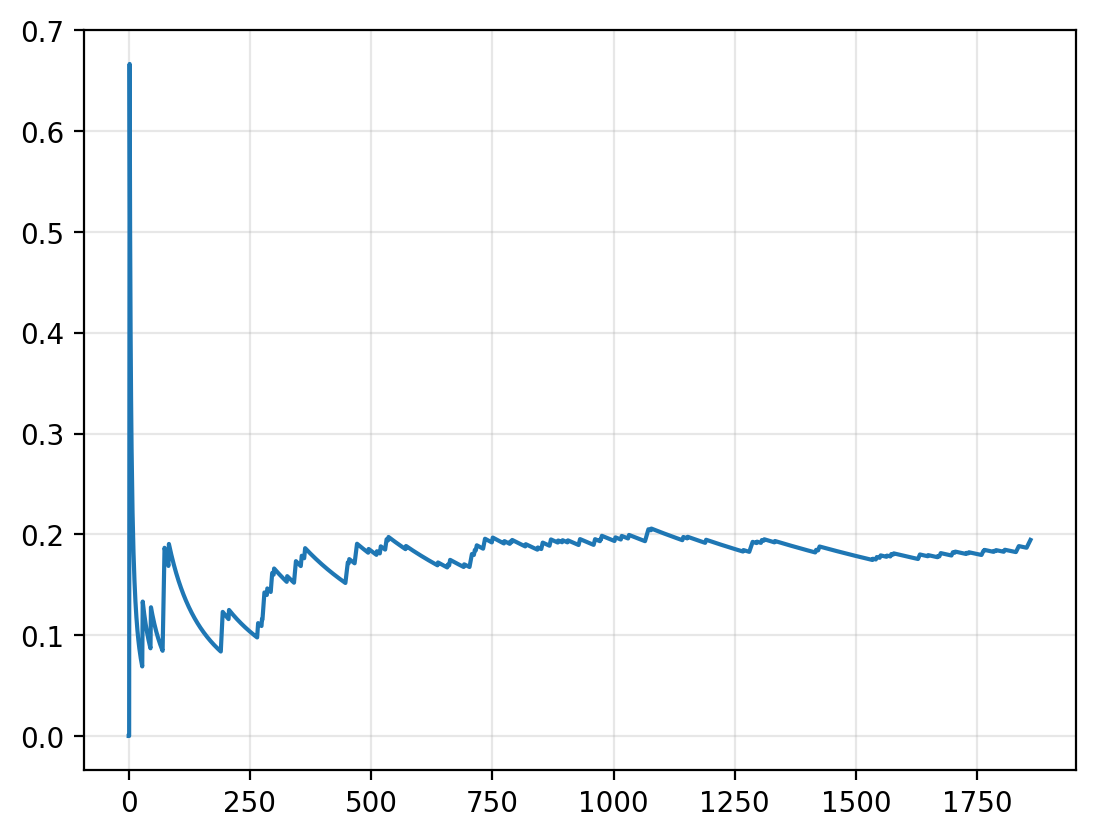

In [65]:
hist = pd.DataFrame({
    "rewards": rewards,
    "rho": rho
})

hist = hist.assign(mult=hist["rewards"] * hist["rho"])
hist.head()

hist["mult"].expanding().mean().plot()
plt.grid(alpha=0.3)